## Introduction

In [9]:
from google.colab import files
uploaded = files.upload()

Saving gender_submission.csv to gender_submission.csv
Saving test.csv to test.csv
Saving train.csv to train.csv


In [10]:
from fastai.imports import *
np.set_printoptions(linewidth=130)

## Data preprocessing

In [12]:
import os
from pathlib import Path

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: path = Path('../input/titanic')
else:
    path = Path('titanic')
    if not path.exists():
        import zipfile,kaggle
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

In [13]:
df = pd.read_csv(path/'train.csv')
tst_df = pd.read_csv(path/'test.csv')
modes = df.mode().iloc[0]

In [15]:
def proc_data(df):
    df['Fare'] = df.Fare.fillna(0)
    df.fillna(modes, inplace=True)
    df['LogFare'] = np.log1p(df['Fare'])
    df['Embarked'] = pd.Categorical(df.Embarked)
    df['Sex'] = pd.Categorical(df.Sex)

proc_data(df)
proc_data(tst_df)

In [16]:
cats=["Sex","Embarked"]
conts=['Age', 'SibSp', 'Parch', 'LogFare',"Pclass"]
dep="Survived"

In [17]:
df.Sex.head()

,Sex
0,male
1,female
2,female
3,female
4,male


In [18]:
df.Sex.cat.codes.head()

,0
0,1
1,0
2,0
3,0
4,1


## Binary splits

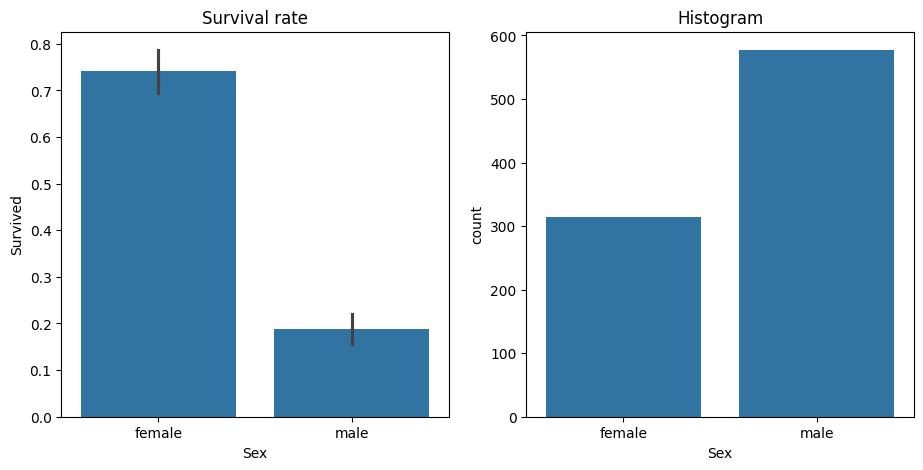

In [19]:
import seaborn as sns

fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.barplot(data=df, y=dep, x="Sex", ax=axs[0]).set(title="Survival rate")
sns.countplot(data=df, x="Sex", ax=axs[1]).set(title="Histogram");

In [20]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
trn_df,val_df = train_test_split(df, test_size=0.25)
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

In [21]:
def xs_y(df):
    xs = df[cats+conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

In [22]:
preds = val_xs.Sex==0

In [23]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y, preds)

0.21524663677130046

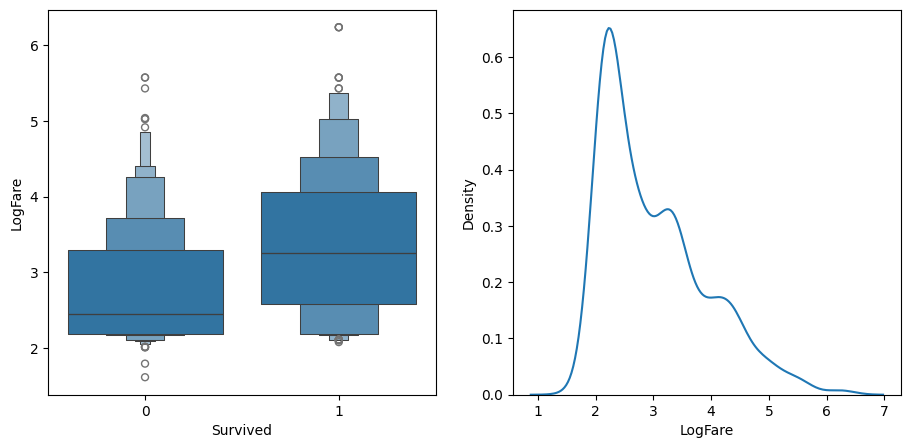

In [24]:
df_fare = trn_df[trn_df.LogFare>0]
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=df_fare, x=dep, y="LogFare", ax=axs[0])
sns.kdeplot(data=df_fare, x="LogFare", ax=axs[1]);

In [25]:
preds = val_xs.LogFare>2.7

In [26]:
mean_absolute_error(val_y, preds)

0.336322869955157

In [27]:
def _side_score(side, y):
    tot = side.sum()
    if tot<=1: return 0
    return y[side].std()*tot

In [28]:

def score(col, y, split):
    lhs = col<=split
    return (_side_score(lhs,y) + _side_score(~lhs,y))/len(y)

In [29]:
score(trn_xs["Sex"], trn_y, 0.5)

np.float64(0.4078753098206398)

In [30]:
score(trn_xs["LogFare"], trn_y, 2.7)

np.float64(0.4718087395209973)

In [31]:
def iscore(nm, split):
    col = trn_xs[nm]
    return score(col, trn_y, split)

from ipywidgets import interact
interact(nm=conts, split=15.5)(iscore);

interactive(children=(Dropdown(description='nm', options=('Age', 'SibSp', 'Parch', 'LogFare', 'Pclass'), value…

In [32]:
interact(nm=cats, split=2)(iscore);

interactive(children=(Dropdown(description='nm', options=('Sex', 'Embarked'), value='Sex'), IntSlider(value=2,…

In [33]:
nm = "Age"
col = trn_xs[nm]
unq = col.unique()
unq.sort()
unq

array([ 0.42,  0.67,  0.75,  0.83,  0.92,  1.  ,  2.  ,  3.  ,  4.  ,  5.  ,  6.  ,  7.  ,  8.  ,  9.  , 10.  , 11.  , 12.  ,
       13.  , 14.  , 14.5 , 15.  , 16.  , 17.  , 18.  , 19.  , 20.  , 21.  , 22.  , 23.  , 24.  , 24.5 , 25.  , 26.  , 27.  ,
       28.  , 28.5 , 29.  , 30.  , 31.  , 32.  , 32.5 , 33.  , 34.  , 34.5 , 35.  , 36.  , 36.5 , 37.  , 38.  , 39.  , 40.  ,
       40.5 , 41.  , 42.  , 43.  , 44.  , 45.  , 45.5 , 46.  , 47.  , 48.  , 49.  , 50.  , 51.  , 52.  , 53.  , 54.  , 55.  ,
       55.5 , 56.  , 57.  , 58.  , 59.  , 60.  , 61.  , 62.  , 64.  , 65.  , 70.  , 70.5 , 74.  , 80.  ])

In [34]:
scores = np.array([score(col, trn_y, o) for o in unq if not np.isnan(o)])
unq[scores.argmin()]

np.float64(6.0)

In [35]:
def min_col(df, nm):
    col,y = df[nm],df[dep]
    unq = col.dropna().unique()
    scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
    idx = scores.argmin()
    return unq[idx],scores[idx]

min_col(trn_df, "Age")

(np.float64(6.0), np.float64(0.47831671750899085))

In [36]:
cols = cats+conts
{o:min_col(trn_df, o) for o in cols}

{'Sex': (np.int8(0), np.float64(0.4078753098206398)),
 'Embarked': (np.int8(0), np.float64(0.478833425731479)),
 'Age': (np.float64(6.0), np.float64(0.47831671750899085)),
 'SibSp': (np.int64(4), np.float64(0.4783740258817423)),
 'Parch': (np.int64(0), np.float64(0.4805296527841601)),
 'LogFare': (np.float64(2.4390808375825834), np.float64(0.4620823937736595)),
 'Pclass': (np.int64(2), np.float64(0.4604826188580666))}

## Creating a decision tree

In [37]:
cols.remove("Sex")
ismale = trn_df.Sex==1
males,females = trn_df[ismale],trn_df[~ismale]

In [38]:
{o:min_col(males, o) for o in cols}

{'Embarked': (np.int8(0), np.float64(0.387558187041091)),
 'Age': (np.float64(6.0), np.float64(0.37398283710105873)),
 'SibSp': (np.int64(4), np.float64(0.38758642275862637)),
 'Parch': (np.int64(0), np.float64(0.3874704821461953)),
 'LogFare': (np.float64(2.803360380906535), np.float64(0.38048562317581447)),
 'Pclass': (np.int64(1), np.float64(0.3815544200436083))}

In [39]:
{o:min_col(females, o) for o in cols}

{'Embarked': (np.int8(0), np.float64(0.4295252982857326)),
 'Age': (np.float64(50.0), np.float64(0.4225927658431646)),
 'SibSp': (np.int64(4), np.float64(0.42319212059713585)),
 'Parch': (np.int64(3), np.float64(0.4193314500446157)),
 'LogFare': (np.float64(4.256321678298823), np.float64(0.413505983329114)),
 'Pclass': (np.int64(2), np.float64(0.3335388911567602))}

In [40]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

m = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs, trn_y);

In [41]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

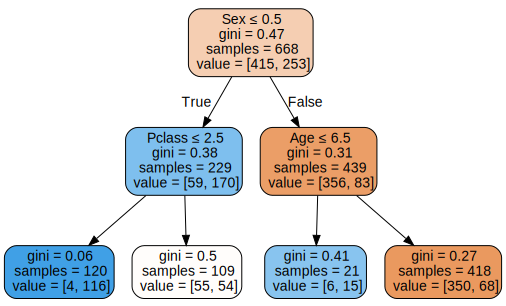

In [42]:
draw_tree(m, trn_xs, size=10)

In [43]:
def gini(cond):
    act = df.loc[cond, dep]
    return 1 - act.mean()**2 - (1-act).mean()**2

In [44]:
gini(df.Sex=='female'), gini(df.Sex=='male')

(np.float64(0.3828350034484158), np.float64(0.3064437162277842))

In [45]:
mean_absolute_error(val_y, m.predict(val_xs))

0.2242152466367713

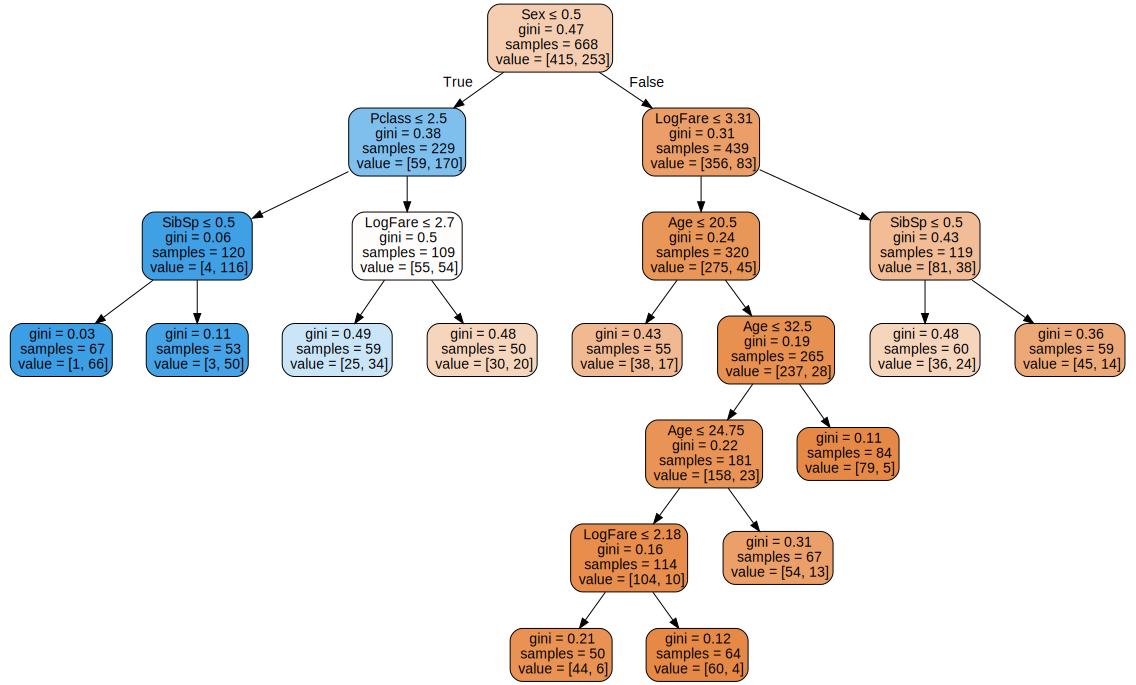

In [46]:
m = DecisionTreeClassifier(min_samples_leaf=50)
m.fit(trn_xs, trn_y)
draw_tree(m, trn_xs, size=25)

In [47]:
mean_absolute_error(val_y, m.predict(val_xs))

0.18385650224215247

In [48]:
tst_df[cats] = tst_df[cats].apply(lambda x: x.cat.codes)
tst_xs,_ = xs_y(tst_df)

def subm(preds, suff):
    tst_df['Survived'] = preds
    sub_df = tst_df[['PassengerId','Survived']]
    sub_df.to_csv(f'sub-{suff}.csv', index=False)

subm(m.predict(tst_xs), 'tree')

In [49]:
df.Embarked.head()

,Embarked
0,S
1,C
2,S
3,S
4,S


In [50]:
df.Embarked.cat.codes.head()

,0
0,2
1,0
2,2
3,2
4,2


## The random forest

In [51]:
def get_tree(prop=0.75):
    n = len(trn_y)
    idxs = random.choice(n, int(n*prop))
    return DecisionTreeClassifier(min_samples_leaf=5).fit(trn_xs.iloc[idxs], trn_y.iloc[idxs])

In [52]:
trees = [get_tree() for t in range(100)]

In [53]:
all_probs = [t.predict(val_xs) for t in trees]
avg_probs = np.stack(all_probs).mean(0)

mean_absolute_error(val_y, avg_probs)

0.2272645739910314

In [54]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(trn_xs, trn_y);
mean_absolute_error(val_y, rf.predict(val_xs))

0.18834080717488788

In [55]:
subm(rf.predict(tst_xs), 'rf')

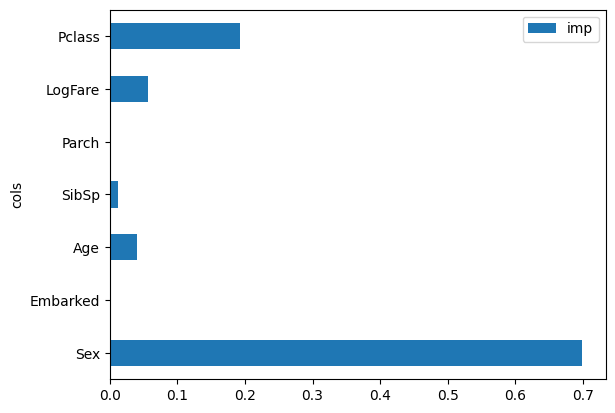

In [56]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=m.feature_importances_)).plot('cols', 'imp', 'barh');

In [59]:
import joblib
joblib.dump(rf, "rf_model.joblib")
joblib.dump(m, "tree_model.joblib")

['tree_model.joblib']